# Weapon Performance Analyzer

for EVE online (www.eveonline.com) using game log files stored on local machine

crafted by Khlaa Sor of KS Endeavours (*work in progress, improvement suggestions welcome via in-game mail*)

In [85]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## 1. Data selection and acquisition.

In [86]:
# Gamelogs directory path
w_dir = input('Gamelogs directory path: ') + '\\'

# Building the list of log files potentially suitable for analysis
log_files = []
with os.scandir(w_dir) as all_files:
    for entry in all_files:
        if entry.stat().st_size > 512: # excluding very small files
            log_files.append(entry.name)

# Sorting the list of log files from newest down
log_files.sort(reverse=True)

# Looking for certain kind of targets
entity = input('Entity to search for (any part of name, case-sensitive, Enter to skip): ')

if entity:
    traced = [] # list to hold file names where target of interest was detected
    for entry in log_files:
        path = w_dir + entry
        with open(path, encoding='utf-8') as file:
            if entity in file.read():
                traced.append(entry)

    if traced:
        log_files = traced
        print(f'Traced in the following op logs ({len(log_files)}):')
    else:
        print('No traces detected.')    
else: 
    print('Not specified')
    print(f'Acquired the following log files ({len(log_files)}):')

Gamelogs directory path:  C:\Users\Maksim Mislavskii\Documents\EVE\logs\Gamelogs
Entity to search for (any part of name, case-sensitive, Enter to skip):  


Not specified
Acquired the following log files (481):


In [87]:
for entry in log_files:
    print(entry)

20210519_125646_91278319.txt
20210519_080243_91278319.txt
20210518_123233_91278319.txt
20210518_045807_91278319.txt
20210518_033858_91278319.txt
20210517_164044_91278319.txt
20210517_054334_91278319.txt
20210517_033635_91278319.txt
20210517_023442_91278319.txt
20210517_012253_91278319.txt
20210516_174916_91278319.txt
20210516_034629_91278319.txt
20210515_135806_91278319.txt
20210515_115600_91278319.txt
20210515_035039_91278319.txt
20210514_171101_91278319.txt
20210514_112532_91278319.txt
20210513_155125_91278319.txt
20210512_074031_91278319.txt
20210511_154834_91278319.txt
20210510_125105_91278319.txt
20210510_072816_91278319.txt
20210510_062440_91278319.txt
20210509_115718_91278319.txt
20210509_010717_91278319.txt
20210508_112449_91278319.txt
20210508_051058_91278319.txt
20210507_112528_91278319.txt
20210507_041841_91278319.txt
20210506_170814_91278319.txt
20210506_121154_91278319.txt
20210505_115104_91278319.txt
20210505_032051_91278319.txt
20210504_133125_91278319.txt
20210504_04111

In [88]:
# Selecting the file to analyse
file_name = input('Log file name to analyze, Enter for latest: ')
if not file_name:
    file_name = log_files[0] # defaulting to the latest file

# Constructing the log file path
file_path = w_dir + file_name
print(file_path)

Log file name to analyze, Enter for latest:  20210517_164044_91278319.txt


C:\Users\Maksim Mislavskii\Documents\EVE\logs\Gamelogs\20210517_164044_91278319.txt


In [89]:
# reading the file and getting rid of the tags in the process
with open(file_path) as log_file:
    lines = [re.sub('<.+?>', '', #  replacing each tag with empty string
                    line.strip() 
                   ) for line in log_file.readlines()]
if lines:
    print(f'Log data loaded: {len(lines)} entries')

Log data loaded: 3330 entries


In [90]:
# printing the log out line by line
for line in lines:
    print(line)

------------------------------------------------------------
Gamelog
Listener: Khlaa Sor
Session Started: 2021.05.17 16:40:44
------------------------------------------------------------
[ 2021.05.17 16:42:17 ] (question) The following items will be redeemed, activated and applied to Khlaa Sor Scimitar Capsuleer Day XVIII SKIN.

Do you wish to proceed?
[ 2021.05.17 16:43:54 ] (question) The following items will be redeemed, activated and applied to Khlaa Sor Guardian Capsuleer Day XVIII SKIN.

Do you wish to proceed?
[ 2021.05.17 17:11:00 ] (None) Undocking from Yuzier V - Moon 1 - Ammatar Fleet Assembly Plant to Yuzier solar system.
[ 2021.05.17 17:11:54 ] (None) Jumping from Yuzier to Tanoo
[ 2021.05.17 17:12:41 ] (None) Jumping from Tanoo to Sasta
[ 2021.05.17 17:13:26 ] (None) Jumping from Sasta to Lashesih
[ 2021.05.17 17:14:14 ] (None) Jumping from Lashesih to Lisudeh
[ 2021.05.17 17:14:56 ] (warning) The price you have chosen is 150,00 % above regional average. Are you sure you 

## 2. Preparing the data for analisys with Pandas.

In [91]:
# Getting a list of all combat related entries:
combat = [line for line in lines if '(combat)' in line]

if entity:
    specific = input('Filter for selected kind of targets (1/Enter):') 
    if specific:
        print(f'Filtering for {entity}')
        combat = [line for line in combat if entity in line]

# Getting a list of damage-exchange entries (by filtering 'misses' and 'attempt' out)
# also replacing '(combat)' with '-' to use as a column separator
hits = [line.replace('(combat)', '-') for line in combat if ('misses' not in line) and ('attempt' not in line)]
# !!! some (PC) entity designations can result in them not being accounted for

# and preparing it for dataframing by turning each entry into a row of cells
hits = [line.strip('[ ').replace(' ]', '') for line in hits]  # cleaning the timestamps
# installing column separators '-' and performing the split
hits = [line.replace(' to ', ' - to - ').replace(' from ', ' - from - ').split(' - ')  for line in hits] 

# Taking only dealt damage entries
dealt = [entry for entry in hits if 'to' in entry]

# Creating the dataframe
columns = ['Time', 'Damage', 'Direction', 'Entity', 'Weapon', 'Token']
dealt_df = pd.DataFrame(data=dealt, columns=columns)

dealt_df.Damage = dealt_df.Damage.astype('int')  # Casting the damage scores to integer
# dealt_df

## 3. Analysing the data and displaying results

In [92]:
# function to produce a list of explode values for pie charts
def pie_exploder(vals):
    """
    :vals: a list of values to be represented by the pie vedges, sorted in descending order for best results
    :return: a list of explode values for pie charts to only explode very narrow vedges
    :required: numpy
    """
    e = 0.01 # default explode value for all vedges
    explode = np.zeros(len(vals)) + e # generating default list of uniform explode values with numpy
    i = 0
    for val in vals:
        if val / sum(vals) < 0.03: #  tiny vedge qualification treshold (fraction of the total sum)
            explode[i] = e #  in the first run, default explode value is applied unchanged
            e += 0.05 #  incrementing the explode value starting from the second encountered tiny vedge
        i += 1

    return explode

### 3.1. Summary Stats

In [93]:
enemies = dealt_df.Entity.unique().tolist() 
print(f'Activated weapons on {len(enemies)} kinds of targets:')
for enemy in enemies:
    print(f' - {enemy}')
print()
weapons = dealt_df.Weapon.unique().tolist()
print(f'Used {len(weapons)} types of weapon systems:')
for weapon in weapons:
    print(f' - {weapon}')
print()

Activated weapons on 16 kinds of targets:
 - Sansha's Scout
 - Centii Loyal Manslayer
 - Centii Loyal Enslaver
 - True Sansha's Plague
 - Centii Loyal Plague
 - Sansha Heavy Missile Battery
 - Centii Loyal Servant
 - Centii Loyal Ravener
 - Centum Mutilator
 - Centum Loyal Mutilator
 - Centatis Daemon
 - Centatis Phantasm
 - Centatis Behemoth
 - Centatis Specter
 - Centum Loyal Hellhound
 - True Sansha's Plague Wreck[KSER](Sanshas Small Commander Wreck)

Used 6 types of weapon systems:
 - Acolyte II
 - Hobgoblin II
 - Mjolnir Light Missile
 - Infiltrator II
 - Hammerhead II
 - Inferno Light Missile



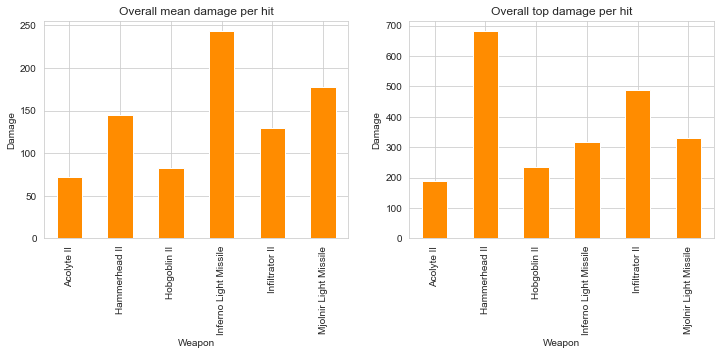

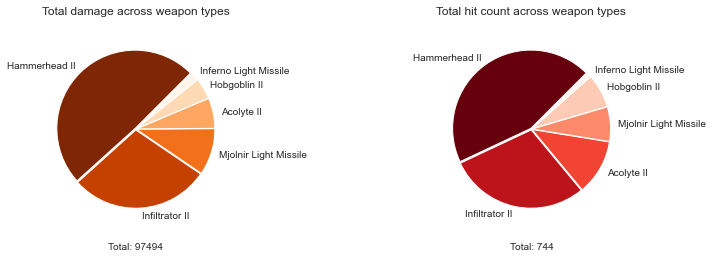

In [94]:
if weapons:
    # data for plotting
    means_per_weapon = dealt_df.groupby(['Weapon']).Damage.mean()#.sort_values(ascending=False)
    totals_per_weapon = dealt_df.groupby(['Weapon']).Damage.sum().sort_values(ascending=False)
    tops_per_weapon = dealt_df.groupby(['Weapon']).Damage.max()#.sort_values(ascending=False)
    hits_per_weapon = dealt_df.Weapon.value_counts()

    #  barcharts of mean and top damage scores per weapon
    plt.figure(figsize=(12,4)) 

    plt.subplot(121)
    means_per_weapon.plot(
        kind='bar', ylabel='Damage', title='Overall mean damage per hit', color='darkorange')

    plt.subplot(122)
    tops_per_weapon.plot(
        kind='bar', ylabel='Damage', title='Overall top damage per hit', color='darkorange')

    plt.show()

    # piecharts of total damage and hit counts per weapon
    plt.figure(figsize=(13,4), facecolor='white') 

    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_weapon)}') #  plotting total damage per weapon
    totals_per_weapon.plot(
        kind='pie', title='Total damage across weapon types', ylabel='',
        radius=.9,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(totals_per_weapon)
    )

    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_weapon.plot(
        kind='pie', title='Total hit count across weapon types', ylabel='',
        radius=.9,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(hits_per_weapon)
    )

    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

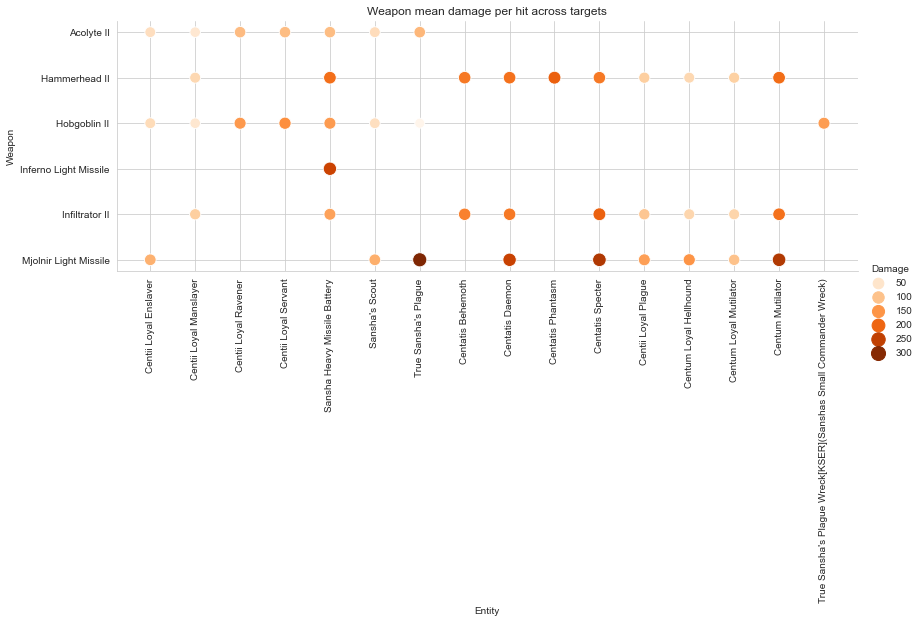

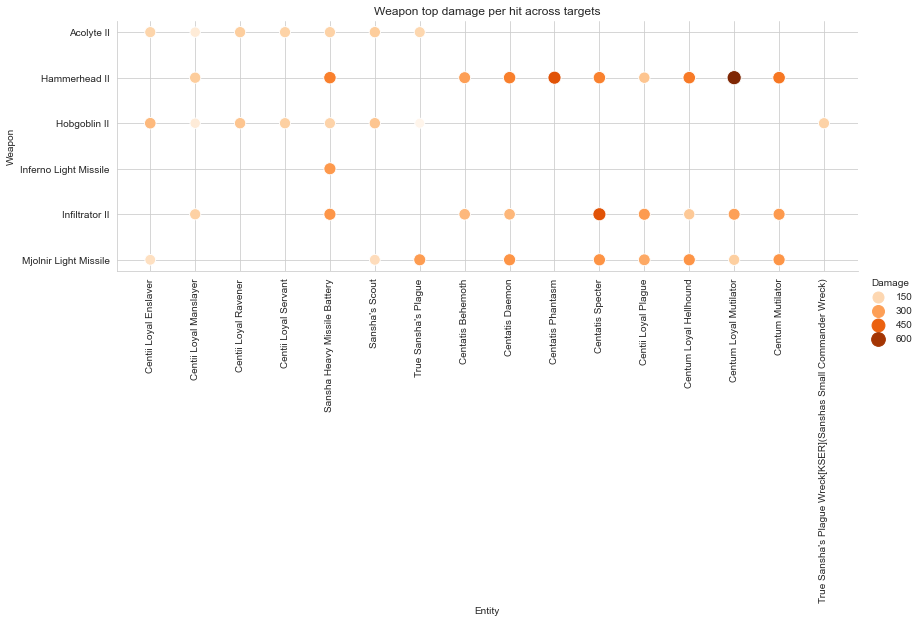

In [95]:
if weapons:
    # Plotting mean and top damage scores per weapon across all targets
    mean_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.mean())
    top_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.max())

    sns.set_style("whitegrid") #  setting the visualization style

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Weapon mean damage per hit across targets')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Weapon top damage per hit across targets')
    plt.show()

Alfa strike per weapon per target - top and bottom:

In [96]:
if weapons:
    print(top_damage_scores.sort_values(by='Damage', ascending=False).head(5), end='\n'*2)
    print(top_damage_scores.sort_values(by='Damage', ascending=False).tail(5), end='\n'*2)

                                       Damage
Weapon         Entity                        
Hammerhead II  Centum Loyal Mutilator     681
Infiltrator II Centatis Specter           487
Hammerhead II  Centatis Phantasm          486
               Centum Mutilator           397
               Centum Loyal Hellhound     389

                                              Damage
Weapon                Entity                        
Mjolnir Light Missile Sansha's Scout             132
                      Centii Loyal Enslaver      119
Acolyte II            Centii Loyal Manslayer      70
Hobgoblin II          Centii Loyal Manslayer      67
                      True Sansha's Plague        10



### 3.2. Weapons performance on each target


Performance on Sansha's Scout:


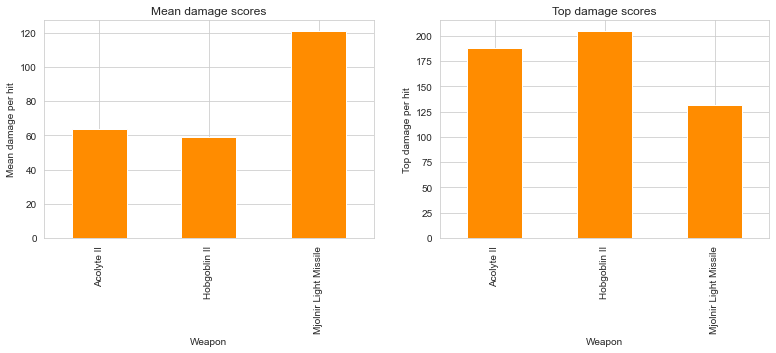

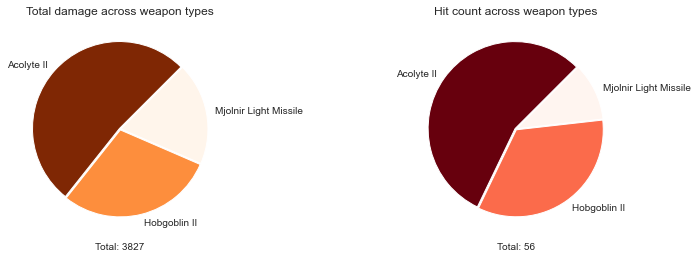


Performance on Centii Loyal Manslayer:


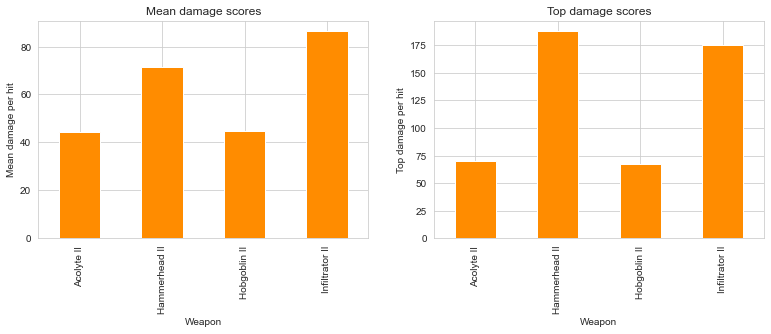

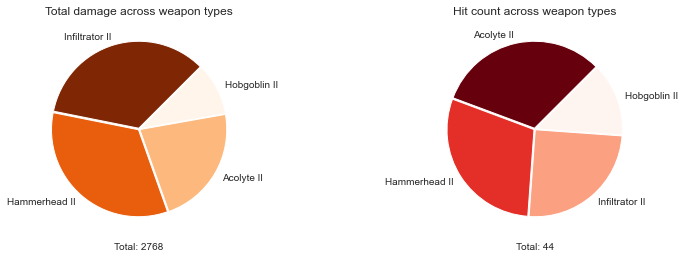


Performance on Centii Loyal Enslaver:


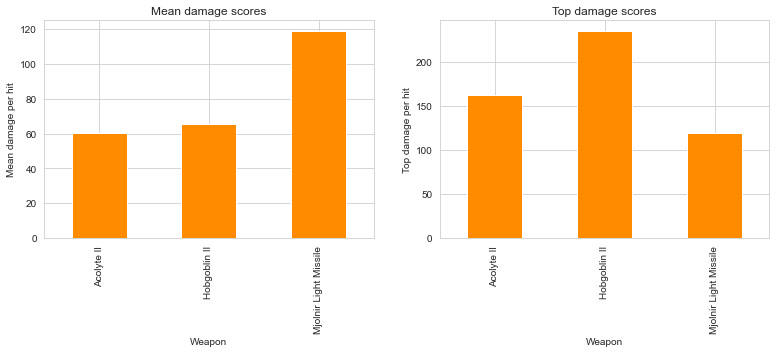

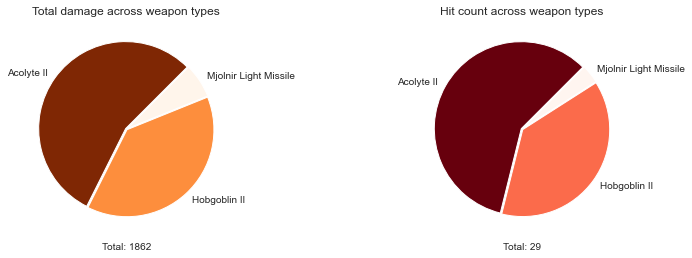


Performance on True Sansha's Plague:


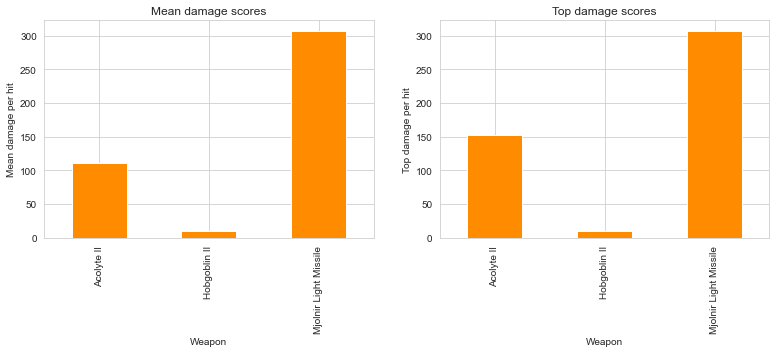

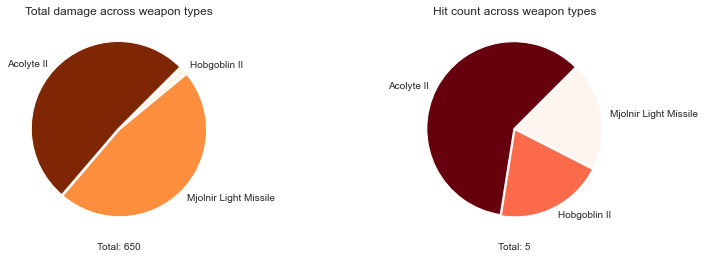


Performance on Centii Loyal Plague:


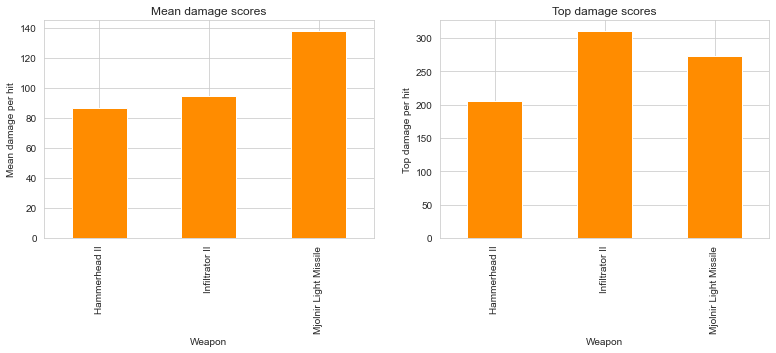

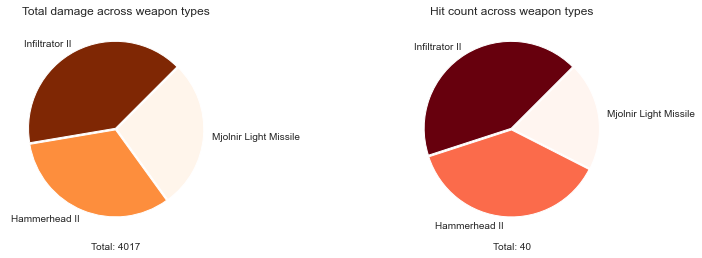


Performance on Sansha Heavy Missile Battery:


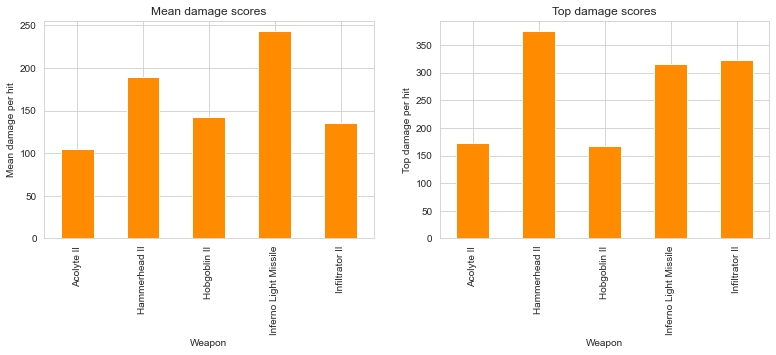

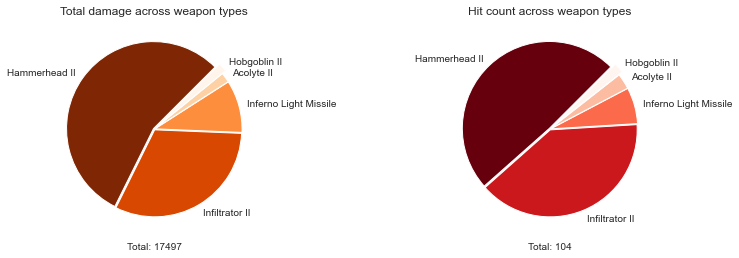


Performance on Centii Loyal Servant:


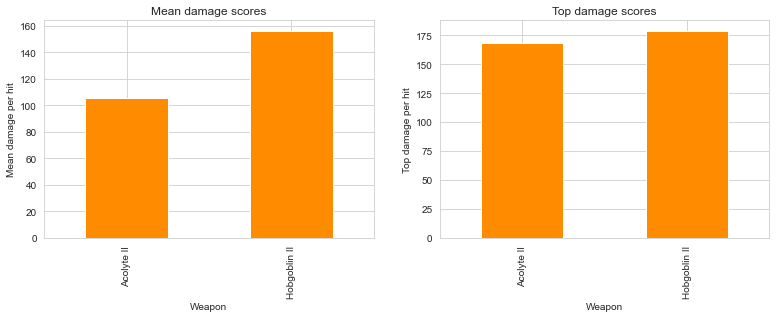

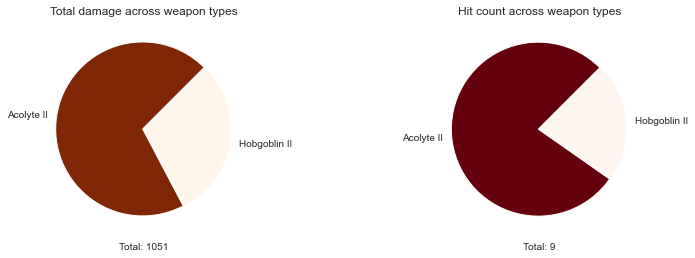


Performance on Centii Loyal Ravener:


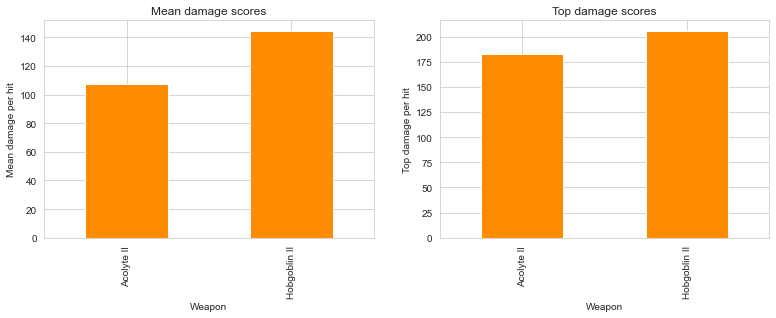

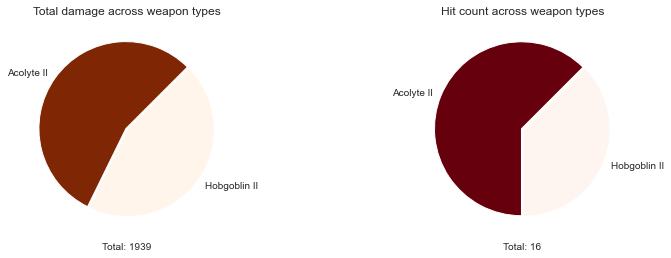


Performance on Centum Mutilator:


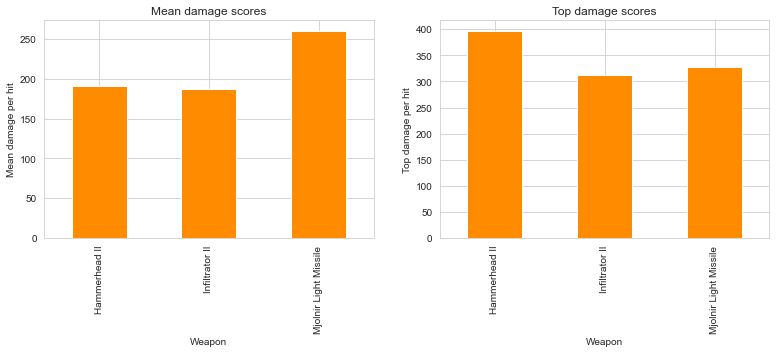

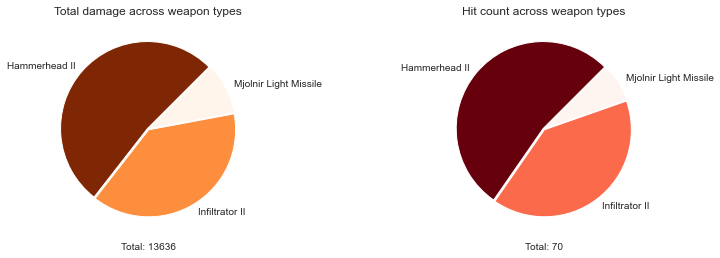


Performance on Centum Loyal Mutilator:


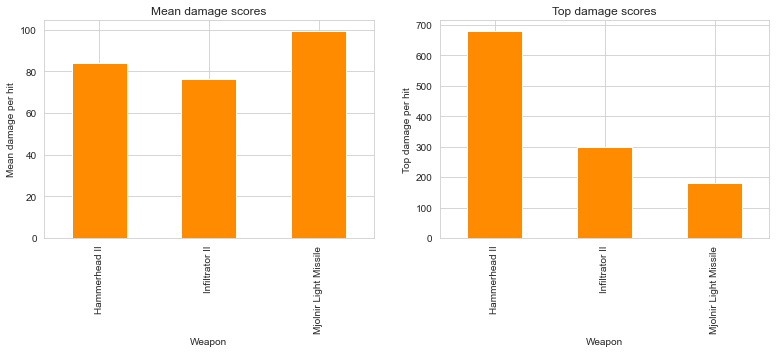

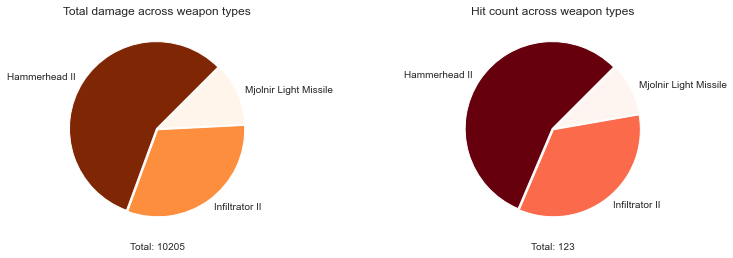


Performance on Centatis Daemon:


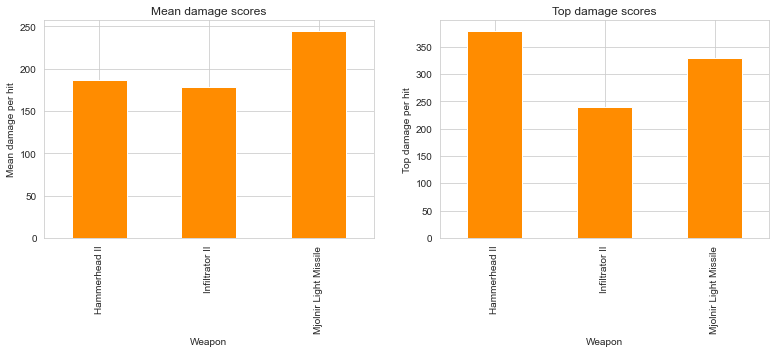

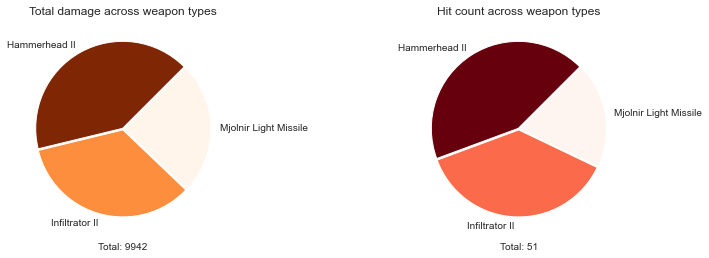


Performance on Centatis Phantasm:


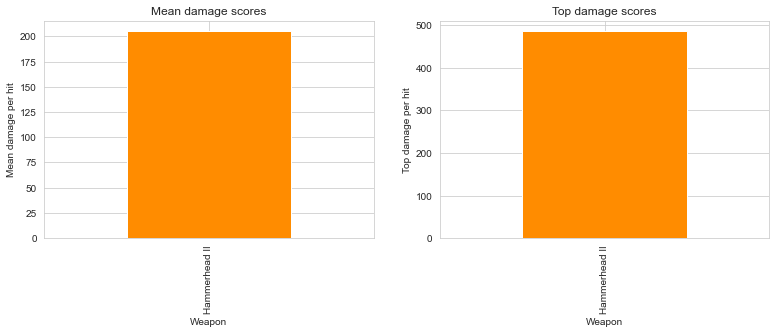

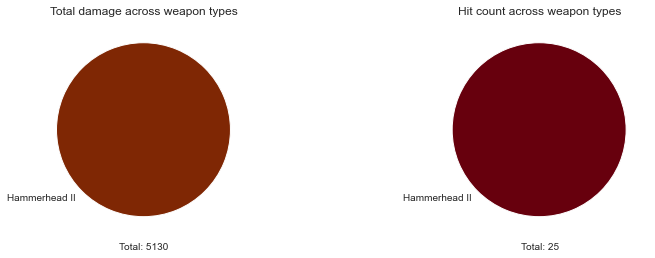


Performance on Centatis Behemoth:


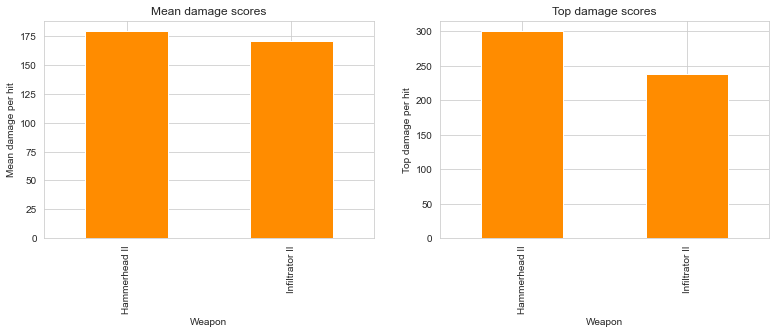

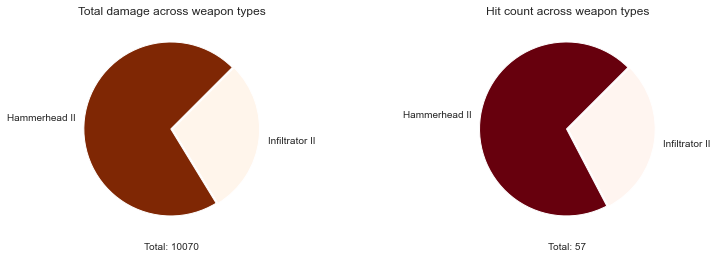


Performance on Centatis Specter:


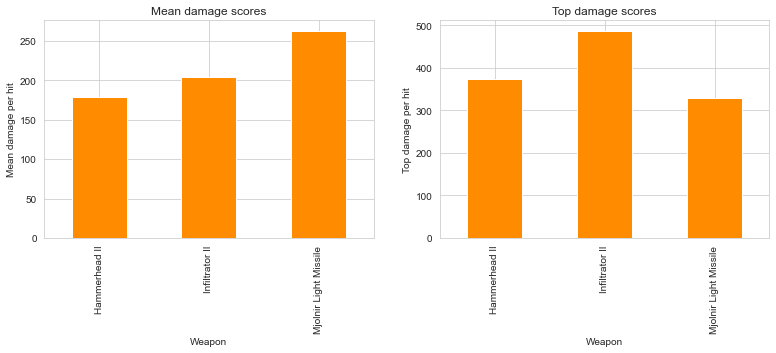

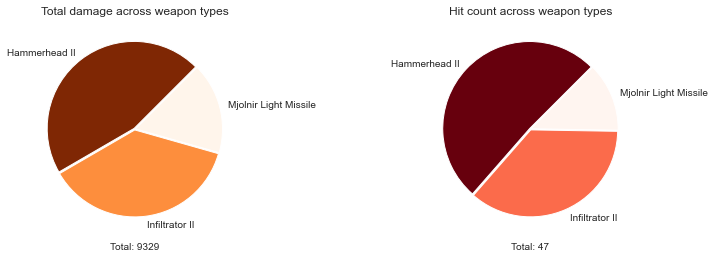


Performance on Centum Loyal Hellhound:


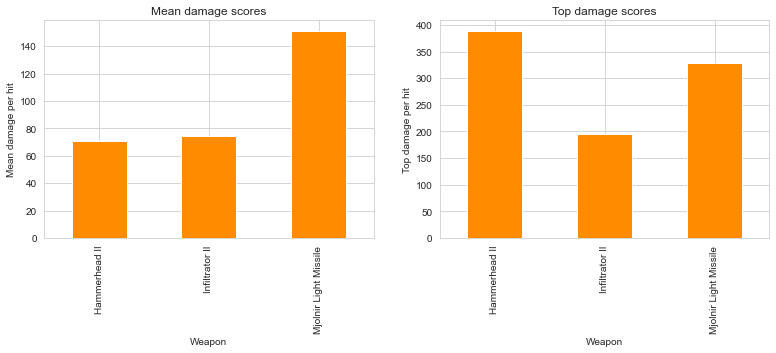

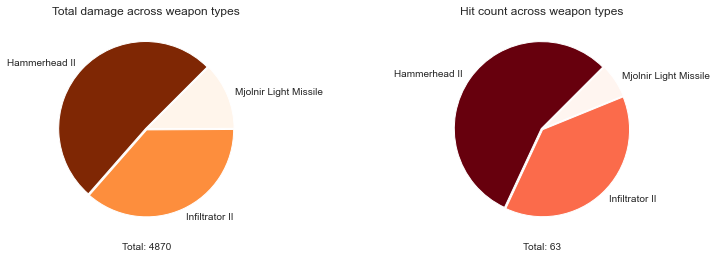


Performance on True Sansha's Plague Wreck[KSER](Sanshas Small Commander Wreck):


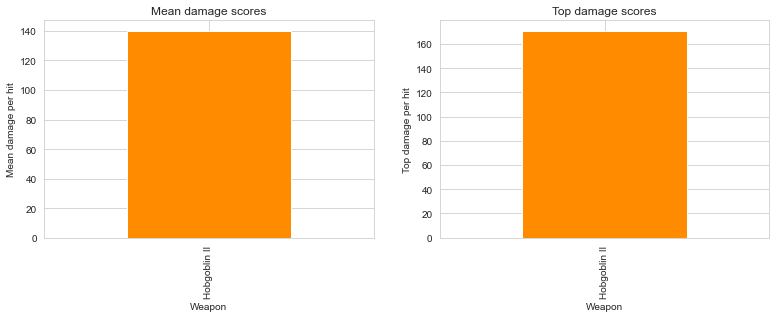

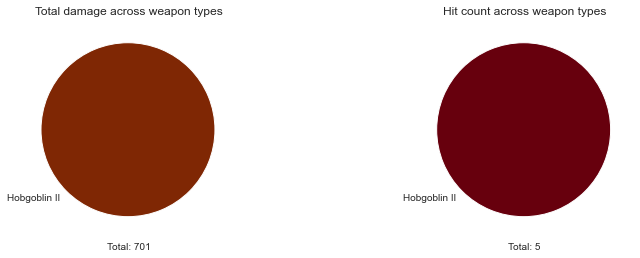

In [97]:
for enemy in enemies:
    print(f'\nPerformance on {enemy}:')
    
    totals_per_weapon = dealt_df.loc[dealt_df['Entity'] == enemy].groupby('Weapon').Damage.sum().sort_values(ascending=False)
    hits_per_weapon = dealt_df.loc[dealt_df['Entity'] == enemy].Weapon.value_counts()
    
    if sum(totals_per_weapon) > 0:
        
        plt.figure(figsize=(13,4)) # mean and top damage barcharts
        
        plt.subplot(121) #  plotting mean damage per hit per weapon 
        dealt_df.loc[dealt_df['Entity'] == enemy].groupby('Weapon').Damage.mean().plot(
            kind='bar', title='Mean damage scores',
            ylabel='Mean damage per hit', 
            color='darkorange'
        )
        plt.subplot(122) #  plotting top damage per hit per weapon 
        dealt_df.loc[dealt_df['Entity'] == enemy].groupby('Weapon').Damage.max().plot(
            kind='bar', title='Top damage scores',
            ylabel='Top damage per hit', color='darkorange'
        )      
        
        plt.show()
        
        plt.figure(figsize=(13,4)) # total damage and hit count pies

        plt.subplot(121, #  plotting total damage across weapon types
                    xlabel=f'Total: {sum(totals_per_weapon)}')
        totals_per_weapon.plot(
            kind='pie', title='Total damage across weapon types',
            # radius=1.1,
            # center=(0,-5),
            cmap='Oranges_r',
            ylabel='', 
            startangle = 45,
            explode = pie_exploder(totals_per_weapon)
        )
        plt.subplot(122, #  plotting hit counts per weapon
                    xlabel=f'Total: {sum(hits_per_weapon)}') 
        hits_per_weapon.plot(
            kind='pie', title='Hit count across weapon types', ylabel='',
            cmap='Reds_r',
            startangle = 45,
            explode = pie_exploder(hits_per_weapon)
        )        
        
        plt.show()
        
    else:
        print('- Zero damage scored', end='\n'*2)
        continue